# Download Hourly Canadian Weather Data

This notebook can be used to browse and download hourly weather data from Environment Canada Weather Stations

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
# import os
import folium
import requests

%matplotlib notebook

token = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A" # your mapbox token
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)


# Search Areas

In [19]:
## Search Areas (e.g. UBC Micromet flux Search_Locatons)
Search_Locatons =  gpd.read_file('https://raw.githubusercontent.com/ubc-micromet/FieldSiteMaps/main/data/FluxTowers.json')
Search_Locatons = Search_Locatons.set_index('Name')
Search_Locatons.head()

,OBJECTID,Longitude,Latitude,Access,WebPlot,Start,Description,geometry
Name,,,,,,,,
BB1,4,-122.984947,49.129360,First gate is a yellow gate on 80th Street nex...,https://ibis.geog.ubc.ca/~micromet/data/burnsb...,2014,A harvested peatland that is undergoing active...,POINT (-122.98496 49.12937)
BB2,5,-122.995163,49.119015,First gate is a yellow gate on 80th Street nex...,https://ibis.geog.ubc.ca/~micromet/data/burnsb...,2019,A harvested peatland that is not undergoing ac...,POINT (-122.99518 49.11902)
DSM,6,-122.895210,49.088196,"Enter the gate through 112th Street, follow th...",https://ibis.geog.ubc.ca/~micromet/data/DeltaS...,2021,A degraded salt marsh in boundary bay.,POINT (-122.89548 49.08905)
RBM,7,-123.196411,49.131161,Get to the West Dyke Trail through Steveston H...,https://ibis.geog.ubc.ca/~micromet/data/Richmo...,2022,A brackish marsh near the mouth of the Fraser ...,POINT (-123.19795 49.13153)


# Met Stations

Filter Data:
* Start year (optional)
    * Calculate record lengths
* Provinces

In [15]:
## Met Stations
Start_Year = 2014
Provinces = ['BRITISH COLUMBIA']

End_Year = datetime.datetime.now().year

Stations = pd.read_csv('station_list/Stations.csv',skiprows=0)

Dates = ['FIRST_DATE','LAST_DATE','HLY_FIRST_DATE','HLY_LAST_DATE','DLY_FIRST_DATE','DLY_LAST_DATE',
         'MLY_FIRST_DATE','MLY_LAST_DATE']

for date in Dates:
    Stations[date] = pd.to_datetime(Stations[date])
    
Stations['HLY_REC_LENGTH'] = Stations['HLY_FIRST_DATE']-Stations['HLY_LAST_DATE']

Stations = Stations.loc[((Stations['HLY_FIRST_DATE'].dt.year<=Start_Year)&
                        (Stations['HLY_LAST_DATE'].dt.year>=Start_Year)&
                        (Stations['ENG_PROV_NAME'].isin(Provinces)))].copy()

Stations = Stations.set_index(Stations['STATION_NAME'],drop = True)


Stations = gpd.GeoDataFrame(Stations,
    geometry=gpd.points_from_xy(Stations['x'],
                                Stations['y']
                               ),
                    crs='WGS1984'
                                  )
# Now we can assign a CRS
WGS_1984='epsg:4326'
Stations.crs = WGS_1984
Stations.head()

,x,y,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA,HLY_REC_LENGTH,geometry
STATION_NAME,,,,,,,,,,,,,,,,,,,,,
SANDSPIT,-131.813889,53.254167,48648,SANDSPIT,BC,BRITISH COLUMBIA,CAN,531515000,-1314850000,PST,...,2022-06-07 12:30:00,2010-06-03,2022-06-07,NaT,NaT,Y,N,Y,-4388 days +22:30:00,POINT (-131.81389 53.25417)
DELTA BURNS BOG,-123.002246,49.125848,49088,DELTA BURNS BOG,BC,BRITISH COLUMBIA,CAN,490733053,-1230008085,PST,...,2022-06-07 12:30:00,2011-01-25,2022-06-07,NaT,NaT,Y,N,Y,-4219 days +12:30:00,POINT (-123.00225 49.12585)
HOPE A,-121.498056,49.368333,49588,HOPE A,BC,BRITISH COLUMBIA,CAN,492206000,-1212953000,PST,...,2022-06-07 12:30:00,2011-10-20,2022-06-07,NaT,NaT,Y,N,Y,-3887 days +18:30:00,POINT (-121.49806 49.36833)
SMITHERS A,-127.182778,54.825278,50130,SMITHERS A,BC,BRITISH COLUMBIA,CAN,544931000,-1271058000,PST,...,2022-06-07 12:30:00,NaT,NaT,NaT,NaT,N,N,Y,-3711 days +18:30:00,POINT (-127.18278 54.82528)
WILLIAMS LAKE A,-122.054444,52.183333,50820,WILLIAMS LAKE A,BC,BRITISH COLUMBIA,CAN,521100000,-1220316000,PST,...,2022-06-07 12:30:00,2012-12-06,2022-06-07,NaT,NaT,Y,N,Y,-3474 days +20:30:00,POINT (-122.05444 52.18333)


# Reproject, Buffer by Radius, and Search
* Use different projection if outside BC

<IPython.core.display.Javascript object>


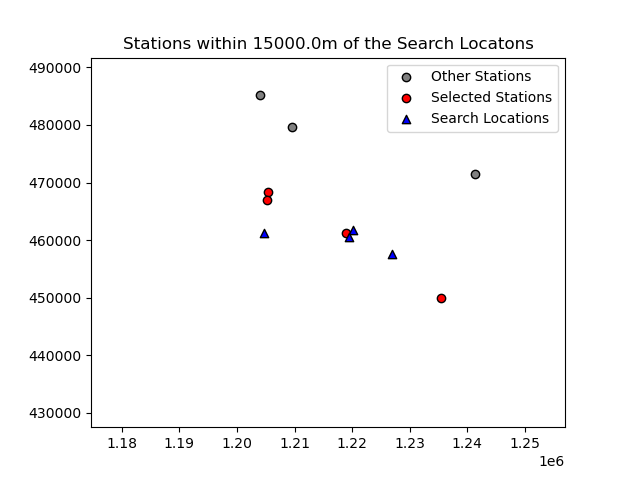

STATION_NAME,DELTA BURNS BOG,VANCOUVER INTL A,VANCOUVER SEA ISLAND CCG,WHITE ROCK CAMPBELL SCIENTIFIC
x,-123.002246,-123.183889,-123.187236,-122.783889
y,49.125848,49.194722,49.1825,49.018056
STN_ID,49088,51442,51357,925
STATION_NAME,DELTA BURNS BOG,VANCOUVER INTL A,VANCOUVER SEA ISLAND CCG,WHITE ROCK CAMPBELL SCIENTIFIC
PROV_STATE_TERR_CODE,BC,BC,BC,BC


In [30]:
## Set to BC Albers
Stations = Stations.to_crs('epsg:3153')
Search_Locatons = Search_Locatons.to_crs('epsg:3153')

## Search Radius
Dist = 1.5e4
Search_Locatons_buffer = Search_Locatons.buffer(Dist)

Select = Stations.assign(**{(key): Stations.within(geom) for key, geom in Search_Locatons_buffer.geometry.items()})

Selection = Select[Select[Search_Locatons.index.values].sum(axis=1)>0].copy()
Not_Selectted = Select[Select[Search_Locatons.index.values].sum(axis=1)==0].copy()

fig,ax=plt.subplots()
Not_Selectted.plot(ax=ax,color='grey',edgecolor='k',label='Other Stations')
Selection.plot(ax=ax,color='red',edgecolor='k',label='Selected Stations')
Search_Locatons.plot(ax=ax,color='blue',edgecolor='k',label='Search Locations',marker='^')

plt.legend()

ax.set_xlim(Search_Locatons.geometry.x.min()-Dist*2,Search_Locatons.geometry.x.max()+Dist*2)
ax.set_ylim(Search_Locatons.geometry.y.min()-Dist*2,Search_Locatons.geometry.y.max()+Dist*2)
ax.set_title('Stations within '+str(Dist)+'m of the Search Locatons')

Selection.T.head()

# Display Results in Interactive Webmap

In [52]:
Map = folium.Map(
    location=[49.12917,-122.98486], zoom_start=10)#, tiles=tileurl, attr='Mapbox')

def pop_Up_Table(row):
    pop_up='''<table>
    <tr><td><b>Station Name: </b></td>><td>'''+row['STATION_NAME']+'''</td><tr>
    <tr><td><b>Start Date: </b></td>><td>'''+row['HLY_FIRST_DATE'].strftime("%d/%m/%Y")+'''</td><tr>
    <tr><td><b>End Date: </b></td>><td>'''+row['HLY_LAST_DATE'].strftime("%d/%m/%Y")+'''</td><tr>
    </table>
    '''
    return (pop_up)

for i,row in Search_Locatons.iterrows():
    print(row['Latitude'],row['Longitude'])
    point=folium.CircleMarker(
            location=[row['Latitude'],row['Longitude']],
            radius=10,
            popup=i,
            fill_opacity = 1,
            fill=True,
            color='black',
            line_weight=.35,
            fill_color='blue'
    ).add_to(Map)

    
    
    
for i,row in Not_Selectted.iterrows():
    point=folium.CircleMarker(
            location=[row['y'],row['x']],
            radius=5,
            popup = folium.Popup(pop_Up_Table(row), min_width=300, max_width=300),
            fill_opacity = 1,
            fill=True,
            color='black',
            line_weight=.35,
            fill_color='grey'
    ).add_to(Map)

    
for i,row in Selection.iterrows():
    point=folium.CircleMarker(
            location=[row['y'],row['x']],
            radius=5,
            popup = folium.Popup(pop_Up_Table(row), min_width=300, max_width=300),
            fill_opacity = 1,
            fill=True,
            color='black',
            line_weight=.35,
            fill_color='red'
    ).add_to(Map)
Map

49.12936019897461 -122.98494720458984
49.119014739990234 -122.99516296386719
49.08819580078125 -122.89521026611328
49.131160736083984 -123.1964111328125


# Download Data

In [68]:
for i,row in Selection.iterrows():
    Root = 'https://api.weather.gc.ca/collections/climate-hourly/items?'

    Start_Year = 2014
    End_Year = 2022

    Range = 'datetime='+str(Start_Year)+'-01-01%2000:00:00/'+str(End_Year)+'-12-31%2000:00:00'

    Station = '&CLIMATE_IDENTIFIER='+str(row['CLIMATE_IDENTIFIER'])

    End = '&sortby=LOCAL_DATE&f=csv&limit=100000&startindex=0'

    Download = (Root+Range+Station+End)
    response = requests.get(Download)
    open("Data/"+str(i)+".csv", "wb").write(response.content)
    print('Downloaded: ',i)
    

Downloaded:  DELTA BURNS BOG
Downloaded:  VANCOUVER INTL A
Downloaded:  VANCOUVER SEA ISLAND CCG
Downloaded:  WHITE ROCK CAMPBELL SCIENTIFIC
